<p style="font-size:30px"><b> Final Model - Weighted majority model </b></p>
 
<p style="font-size:20px">The main assumptions of this model are following:</p>
<ol>
    <li>
        There are four graphs, which represents interactions in society: 
        <ul>
            <li><b>G</b> - rectangular neighbourhood network</li>
            <li><b>K</b> - social interactions network</li>
            <li><b>K_temp</b> - temporary social interactions network (generates for each iteration)</li>
            <li><b>L</b> - social media network (social media are for or against EV - it changes in each iteration)</li>
        </ul>
    </li>
    <li>
        There are two different possibilities in opinions:
        <ul>
            <li><b>1</b> - agent is against EV</li>
            <li><b>-1</b> - agent is for EV</li>
        </ul>
    </li>
    <li>
        <font color="red">At the beginning there are agents with different opinions (based on real number of EV)</font>
    </li>
    <li>
        There are two possibilities of changing opinion by agents:
        <ul>
            <li><b>independent flip</b> - with a given probability $p$ agent changes its opinions independently</li>
            <li><b>conformity flip</b> - <font color="red">if value of neighbours opinion is higher than zero, it becomes against electric vehicles, otherwise it is for electric vehicles. Value of neighbours opinion is a sum of opinions of q randmoly chosen neighbours from every considered network multiplied by coefficient of weight for every network </font></li>
        </ul>
</ol>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import trange
import pickle

In [2]:
def spinson_independent_flip(opinions, spinson):
    opinions[spinson] = -1 if opinions[spinson] == 1 else 1

    return opinions

In [3]:
def spinson_conformity_flip(graphs, opinions, spinson, q, coefficients):
    neighbours_opinion = 0
    for i in range(len(graphs)):
        if len(list(graphs[i].neighbors(spinson))) < q:
            neighbours = list(graphs[i].neighbors(spinson))
        else:
            neighbours = random.sample(list(graphs[i].neighbors(spinson)), q)
        if len(neighbours) != 0:
            neighbours_opinions = [opinions[neighbour] for neighbour in neighbours]
            neighbours_opinion += coefficients[i]*sum(neighbours_opinions)/len(neighbours)
    if neighbours_opinion > 0:
        opinions[spinson] = 1
    elif neighbours_opinion < 0:
        opinions[spinson] = -1

    return opinions

In [4]:
def q_voter_simulation(graphs, p, q, iterations, coefficients, h):
    magnetization = []

    opinions = [1]*len(G)
    while opinions.count(-1) < 2:  # agents have different opinions at the beginning of simulation
        opinions[random.randint(0, len(G)-1)] = -1
    
    social_media_opinion = [1] 
    opinions = opinions + social_media_opinion
    
    magnetization.append(sum(opinions[:-1])/len(graphs[0]))
    for i in range(iterations):
        # in every iteration graph of temporary interactions and opinion of social media is changing
        graphs[-2] = nx.fast_gnp_random_graph(len(graphs[0].nodes()), random.uniform(0.0001, 0.001))
        if random.random() < h: # social media influence change opinion
            opinions[-1] = -1
        else:
            opinions[-1] = 1
        # choosing neighbours
        for i in range(len(graphs[0])):
            spinson = random.choice(list(graphs[0].nodes()))  #  chooses one random node
            if random.random() < p:  # does it act independently?
                if random.random() < 0.5:  # the same probability to change opinion
                    opinions = spinson_independent_flip(opinions, spinson)
            else:
                opinions = spinson_conformity_flip(graphs, opinions, spinson, q, coefficients)

        magnetization.append(sum(opinions[:-1])/len(graphs[0]))

    return magnetization

In [5]:
def calculate_magnetization(graphs, p, q, mc, iterations, coefficients, h):

    magnetization = np.zeros(iterations+1)
    for i in range(mc):    
        magnetization = magnetization + q_voter_simulation(graphs, p, q, iterations, coefficients, h)
    magnetization = magnetization/mc
                    
    return magnetization

## Loading saved

In [6]:
G = nx.read_gpickle('small_network_neighbourhood.pickle')
K = nx.read_gpickle('small_social_neighbourhood.pickle')
L = nx.read_gpickle('small_social_media.pickle')

# Simulations

## Magnetization for different values of $q = (1, 10, 10)$ and $p=0.01$

In [7]:
graphs = [G, K, None, L]
p = 0.01
h = 0.5
mc = 20
iterations = 120
coefficients = [0.25, 0.25, 0.25, 0.25]

In [8]:
magnetizations = []
for q in trange(1, 11):
    x = calculate_magnetization(graphs, p, q, mc, iterations, coefficients, h)
    magnetizations.append(x)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.92s/it]


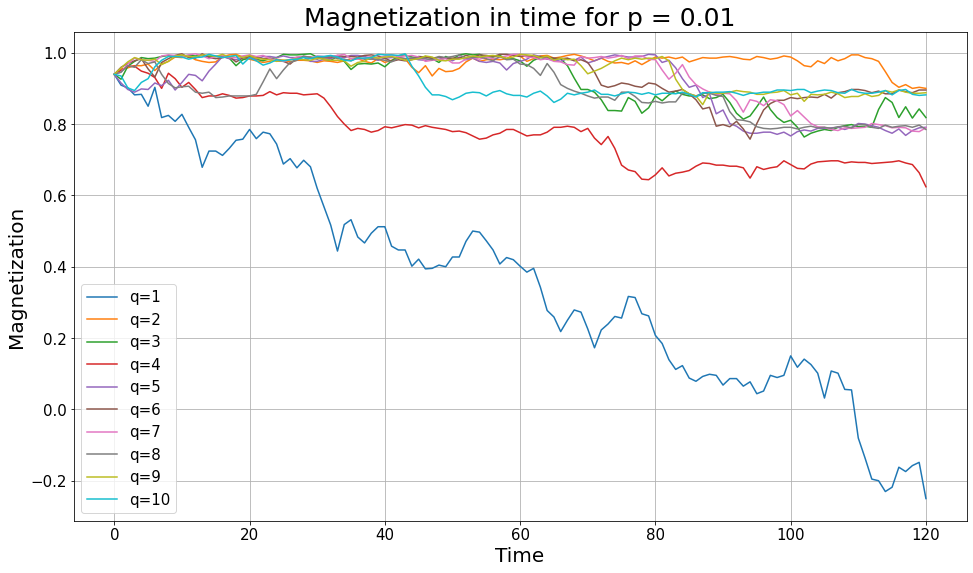

In [9]:
plt.figure(figsize=(16, 9))
for i, magnetization in enumerate(magnetizations):
    plt.plot(range(0, len(magnetization)), magnetization, label=f'q={i+1}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title(f'Magnetization in time for p = {p}', fontsize=25)
plt.grid()
plt.legend(prop={'size': 15})